# Import libraries

In [1]:
import glob
from tqdm import tqdm
import datetime
import re
import pandas as pd
import seaborn as sns
import warnings
import os
import pickle
import numpy as np
import utils as ut
import math
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import norm
import matplotlib.patches as mpatches
import matplotlib
from scipy import stats
import matplotlib.colors as mcolors
import matplotlib.lines as mlines
import random
from scipy.optimize import linear_sum_assignment
from sklearn.model_selection import KFold

# Fetch data

In [6]:
Animal_List = ['QP032', 'QP033', 'QP034','QP049', 'QP050', 
               'QP051', 'QP062', 'QP063', 'QP070', 'QP071', 'QP079']

# Define the path to the cache file
cache_path = '/Users/quentin/Desktop/HeadFixedBehavior/Data/'
cache_file = os.path.join(cache_path, "all_data_cont.pkl")

# Check if the cache file exists
if os.path.exists(cache_file):
    # If the cache file exists, load the data from the cache
    with open(cache_file, "rb") as f:       
        all_data_cont = pickle.load(f)
else:
    # If the cache file does not exist, load the data from the remote server
    all_data_cont = pd.DataFrame()
    for animal in Animal_List:
        try:
            # Load the data for the current animal and add it to the dictionary
            animal_data = ut.get_animal_data('/Volumes/akrami/Quentin/Head_Fixed_Behavior/Data/',
                                             animal, 
                                             'SOUND_CAT_CONT',
                                             'Trial_Summary')
            all_data_cont = pd.concat([all_data_cont, animal_data])
        except:
            # If there is an error loading the data, skip the current animal
            pass

    # Save the data to the cache file
    with open(cache_file, "wb") as f:
        pickle.dump(all_data_cont, f)

# Filter data

In [30]:
data_df = ut.relabel_ELV(all_data_cont) # Re-label appropriately
data_df = ut.remove_blocks(data_df, 'QP032', [17, 18]) # blocks with wrong distribution
data_df = ut.remove_blocks(data_df, 'QP070', [38, 39]) # spout alignment problem
# only keep data where antibias is False or np.nan
data_df = data_df[(data_df.Anti_Bias == False) | (pd.isna(data_df.Anti_Bias))].reset_index(drop=True)
data_df = ut.filter_min_trials(data_df, 100) # Keep at least 100 valid trials per sessions
data_df = ut.threshold_cutoff(data_df, threshold = 0.7) # Only keep sessions where %correct is > threshold

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    data_df = ut.filter_lapses(data_df, threshold = 0.75) # Remove sessions with lapse rates > 20%
    
data_df = ut.add_dist_block(data_df) # Track distribution and mouse specific block_nbs
data_df = ut.check_distributions(data_df, n = 1) # Check thal all subjects have been exposed to all distributions
# data_df = make_blocks_equal(data_df) # Check that all subjects have same number of blocks on each distribution (optional) 
data_df = data_df[data_df['Distribution'].notna()].reset_index(drop=True) # Check distributions are valid
# Ensure thal all blocks follow the desired order (e.g.   ['Uniform', 'Asym_right', 'Asym_left']) (optional)
# data_df = sort_consec_dist(data_df, ['Uniform', 'Asym_right', 'Asym_left']) 
# save data_df to csv as post_processed_data.csv
data_df.to_pickle(cache_path + 'post_processed_data.pkl')

# Setup

In [12]:
import numpy.random as npr
import ssm
from ssm.util import find_permutation

# npr.seed(0)

## Initialize

In [1252]:
# Set the parameters of the GLM-HMM
num_states = 2       # number of discrete states
obs_dim = 1           # number of observed dimensions
num_categories = 2    # number of categories for output
input_dim = 2         # input dimensions

glmhmm = ssm.HMM(num_states, obs_dim, input_dim, observations="input_driven_obs", 
                   observation_kwargs=dict(C=num_categories), transitions="standard")

## Format Data  

In [1253]:
inpts, choices, animal_df = ut.format_data_hmmglm(data_df[data_df.Distribution == 'Asym_left'],
                                                        'QP062', input_dim = input_dim)

## MLE

In [1254]:
N_iters = 10000 # maximum number of EM iterations. Fitting with stop earlier if increase in LL is below tolerance specified by tolerance parameter
fit_ll = glmhmm.fit(choices, inputs=inpts, method="em", num_iters=N_iters, tolerance=10**-4)

  0%|          | 0/10000 [00:00<?, ?it/s]

## Retrieve Parameters

In [1255]:
color_dict = {0: '#ff7f00', 1: '#4daf4a', 2: '#377eb8'
              , 3: '#e41a1c', 4: '#984ea3', 5: '#a65628',
                6: '#f781bf', 7: '#999999', 8: '#a6cee3',   
                9: '#1f78b4', 10: '#b2df8a', 11: '#33a02c',
                12: '#fb9a99', 13: '#fdbf6f', 14: '#cab2d6',
                15: '#ffff99', 16: '#b15928', 17: '#8dd3c7',
                18: '#ffffb3', 19: '#bebada', 20: '#fb8072'
}

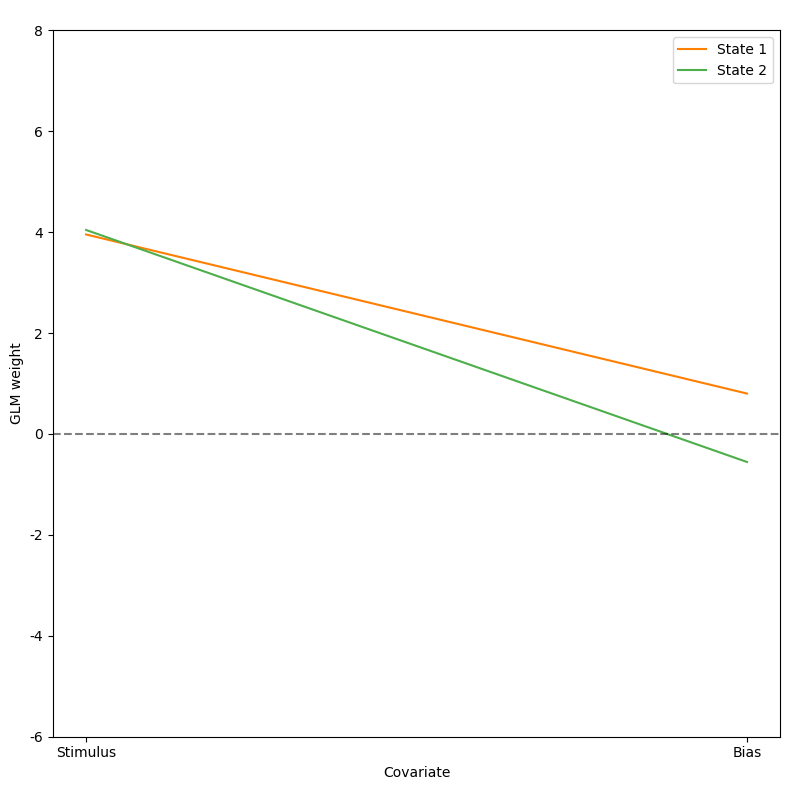

In [1256]:
ut.plot_glmhmm_weights(glmhmm, num_states = num_states, input_dim = input_dim, 
                       color_dict = color_dict,
                       save_path = None)

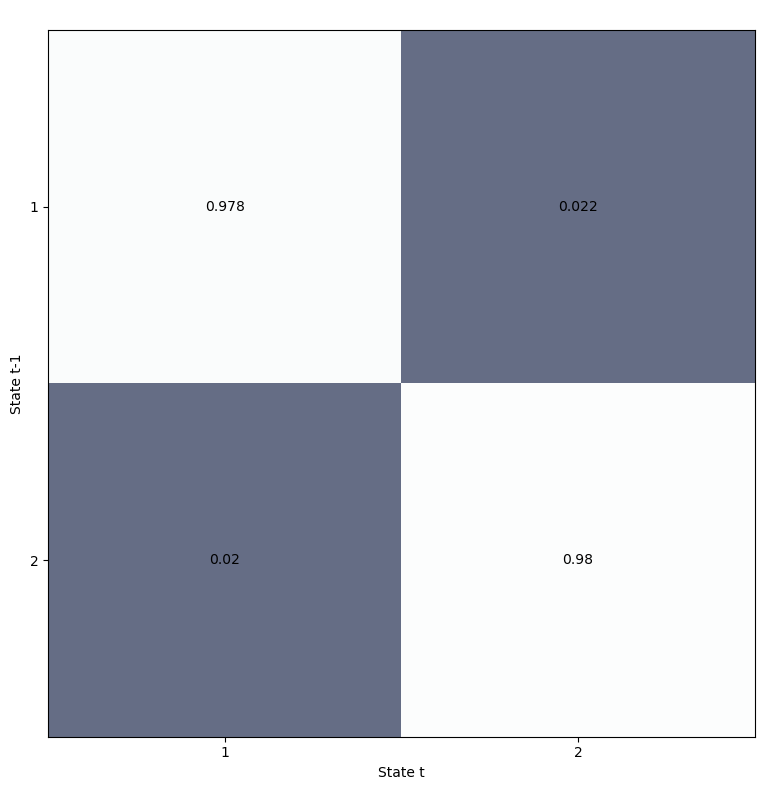

In [1257]:
ut.plot_glmhmm_trans_mat(glmhmm, num_states = num_states, decimals = 3, 
                         save_path = None)

In [1258]:
# Get expected states:
posterior_probs = [glmhmm.expected_states(data=data, input=inpt)[0]
                for data, inpt
                in zip(choices, inpts)]

In [1259]:
# concatenate posterior probabilities across sessions
posterior_probs_concat = np.concatenate(posterior_probs)
# get state with maximum posterior probability at particular trial:
state_max_posterior = np.argmax(posterior_probs_concat, axis = 1)
# now obtain state fractional occupancies:
_, state_occupancies = np.unique(state_max_posterior, return_counts=True)
state_occupancies = state_occupancies/np.sum(state_occupancies)
# add state_max_posterior to animal_df

animal_df['state'] = state_max_posterior

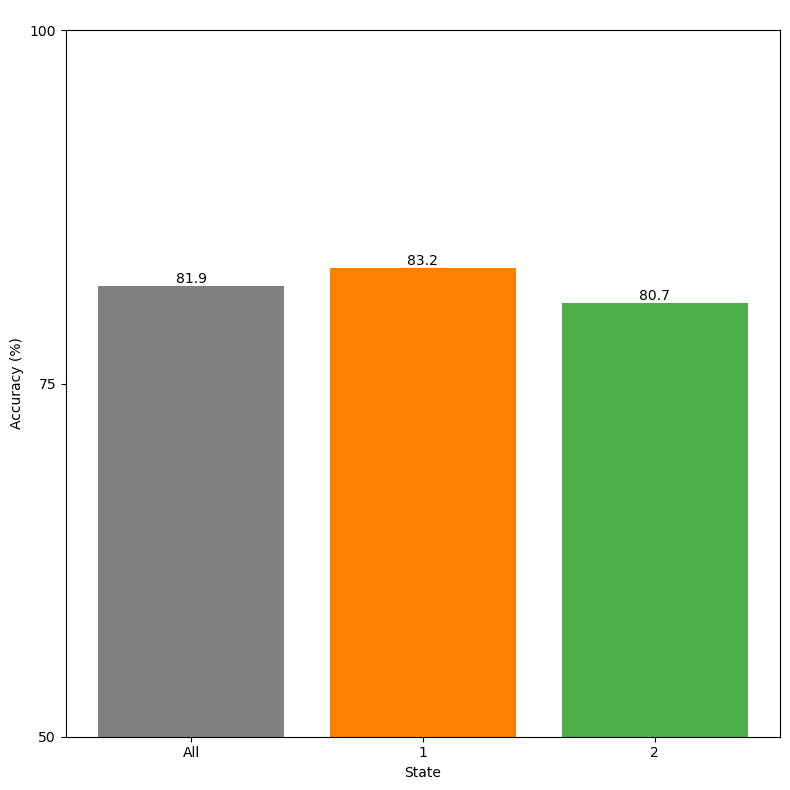

In [1260]:
ut.plot_accuracy_by_state(animal_df, num_states = num_states, color_dict = color_dict,
                          save_path = None)

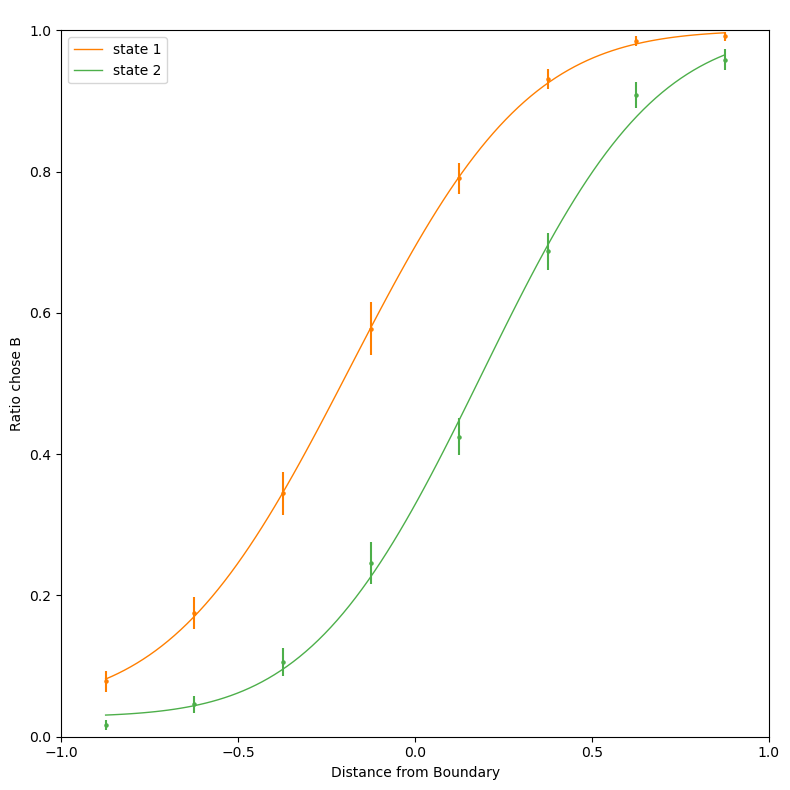

In [1261]:
ut.plot_psycho_by_state(animal_df, num_states, color_dict = color_dict,
                        save_path = None)

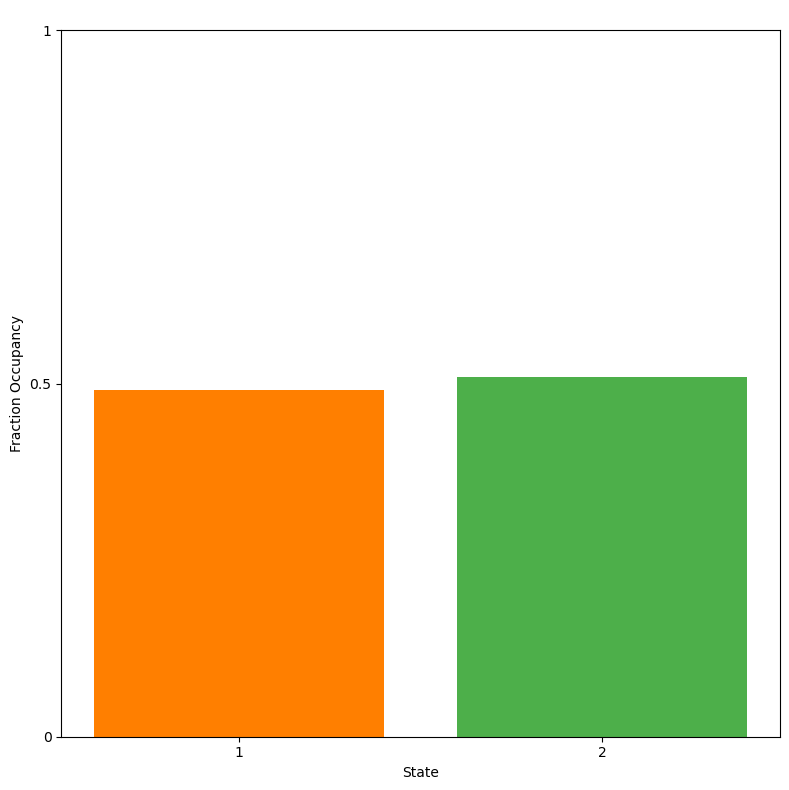

In [1262]:
ut.plot_frac_state_occupancies(state_occupancies = state_occupancies, 
                               num_states = num_states, 
                               color_dict = color_dict,
                               save_path = None)

In [1263]:
# insert interrption here
raise KeyboardInterrupt("Stopped execution at this cell.")

KeyboardInterrupt: Stopped execution at this cell.

In [ ]:
# # plot_state_probabilities for all sessions
# for sess_id in range(len(posterior_probs)):
#     ut.plot_state_probabilities(posterior_probs, sess_id, num_states, color_dict, title='Session ' + str(sess_id),
#                                 legend_bbox = (0.62, 0.4, 0.2, 0.2),
#                                 save_path = None)

In [1264]:
inpts, choices, animal_df = ut.format_data_hmmglm(data_df[data_df.Distribution == 'Asym_left'],
                                                        'QP062', input_dim = input_dim)

In [1265]:
N_iters = 200 # maximum number of EM iterations. Fitting with stop earlier if increase in LL is below tolerance specified by tolerance parameter
num_runs = 5
total_states = 6
np.random.seed(0) 
mse_means = []

for state in range(2, total_states+1):
    recovered_weights_list = [] 
    num_states = state
    for run in range(num_runs):
        glmhmm = ssm.HMM(num_states, obs_dim, input_dim, observations="input_driven_obs", 
                    observation_kwargs=dict(C=num_categories), transitions="standard")
        _ = glmhmm.fit(choices, inputs=inpts, method="em", num_iters=N_iters, tolerance=10**-4)

        log_likelihood = glmhmm.log_likelihood(choices, inputs=inpts)
        recovered_weights = glmhmm.observations.params
        recovered_weights_list.append(recovered_weights)
    mse_values = []
    num_matrices = len(recovered_weights_list)
    for i in range(num_matrices):
        for j in range(i + 1, num_matrices):
            matrix1 = recovered_weights_list[i]
            matrix2 = recovered_weights_list[j]
            # Reshape matrix1 and matrix2 to have a 2D shape
            matrix1 = matrix1.reshape(-1, matrix1.shape[-1])
            matrix2 = matrix2.reshape(-1, matrix2.shape[-1])
            
            #  Calculate the pairwise distances between rows
            distances = np.linalg.norm(matrix1[:, np.newaxis] - matrix2, axis=-1)

            # Apply the Hungarian algorithm to minimize the total distance
            row_indices, col_indices = linear_sum_assignment(distances)

            # Apply the row permutation to align matrix2
            aligned_matrix2 = matrix2[col_indices]

            mse = np.mean((matrix1 - aligned_matrix2)**2)
            # mse = np.mean((matrix1 - matrix2)**2)
            mse_values.append(mse)
    mse_mean = np.mean(mse_values)
    mse_means.append(mse_mean)    
    # print the mean MSE value for each state
    print("State: {}".format(state))
    print("Mean MSE: {}".format(np.mean(mse_means)))

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

State: 2
Mean MSE: 0.11913486992792281


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

State: 3
Mean MSE: 0.06074531206592185


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

State: 4
Mean MSE: 0.052779053476767424


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

State: 5
Mean MSE: 0.051452133610615305


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

State: 6
Mean MSE: 0.08875558088004218


In [2]:
# Define the range of numbers of states to evaluate
n_states_range = range(1, 5)

# Initialize a KFold object to generate the train/validation indices for each fold
n_splits = 5
N_iters = 200
kf = KFold(n_splits)

# Define a dictionary to store the cross-validation results
cv_scores = {}

# Loop over the number of states to evaluate
for n_states in n_states_range:
    # Initialize a new HMM-GLM with the current number of states
    hmm_glm = ssm.HMM(n_states, obs_dim, input_dim, observations="input_driven_obs", 
                   observation_kwargs=dict(C=num_categories), transitions="standard")
    # Initialize an array to store the validation log-likelihoods for the current number of states
    val_scores = np.zeros(n_splits)
    # Loop over the folds generated by the KFold object
    for i_fold, (train_indices, val_indices) in enumerate(kf.split(inpts)):
        
        # Split the data into training and validation sets for the current fold
        x_train_fold = [inpts[i] for i in train_indices]
        y_train_fold = [choices[i] for i in train_indices]
        x_val_fold = [inpts[i] for i in val_indices]
        y_val_fold = [choices[i] for i in val_indices]

        
        
        # Fit the HMM-GLM to the training data for the current fold
        _ = hmm_glm.fit(y_train_fold, inputs=x_train_fold, method="em", num_iters=N_iters, tolerance=10**-4)
        
        # Evaluate the log-likelihood of the validation data for the current fold
        val_scores[i_fold] = hmm_glm.log_likelihood(y_val_fold, inputs=x_val_fold)
    
    # Compute the mean validation score across all folds for the current number of states
    cv_scores[n_states] = np.mean(val_scores)

# Print the cross-validation scores for each number of states
for n_states in n_states_range:
    print(f"n_states = {n_states}, CV score = {cv_scores[n_states]}")


NameError: name 'ssm' is not defined

In [ ]:
# Define the range of numbers of states to evaluate
n_states_range = range(1, 5)

# Initialize a KFold object to generate the train/validation indices for each fold
n_splits = 5
N_iters = 5
kf = KFold(n_splits)

# Define a dictionary to store the cross-validation results
cv_scores = {}

# Loop over the number of states to evaluate
for n_states in n_states_range:
    # Initialize a new HMM-GLM with the current number of states
    hmm_glm = ssm.HMM(n_states, obs_dim, input_dim, observations="input_driven_obs", 
                   observation_kwargs=dict(C=num_categories), transitions="standard")
    # Initialize an array to store the validation log-likelihoods for the current number of states
    val_scores = np.zeros(n_splits)
    # Loop over the folds generated by the KFold object
    for i_fold, (train_indices, val_indices) in enumerate(kf.split(inpts)):
        # Split the data into training and validation sets for the current fold
        x_train_fold = [inpts[i] for i in train_indices]
        y_train_fold = [choices[i] for i in train_indices]
        x_val_fold = [inpts[i] for i in val_indices]
        y_val_fold = [choices[i] for i in val_indices]
        # Perform training 100 times for each fold
        for _ in range(100):
            # Fit the HMM-GLM to the training data for the current fold
            _ = hmm_glm.fit(y_train_fold, inputs=x_train_fold, method="em", num_iters=N_iters, tolerance=10**-4)
            # Evaluate the log-likelihood of the validation data for the current fold
            val_scores[i_fold] = hmm_glm.log_likelihood(y_val_fold, inputs=x_val_fold)
    # Compute the mean validation score across all folds for the current number of states
    cv_scores[n_states] = np.mean(val_scores)

# Print the cross-validation scores for each number of states
for n_states in n_states_range:
    print(f"n_states = {n_states}, CV score = {cv_scores[n_states]}")
